# SD-TSIA 211 -- Computer lab 
```yaml
Name: Liyao JIAO
Date: Jan 12 2024
```
[Github](https://github.com/Lupin2019/tele_comme_pari/tree/dev/SD211/TP_least_squares)

## 1. Introduciton

The data is composed of measurements with a roughly two-hour sampling rate together with 4 key performance indicators (KPIs). Our mission is thus to reverse-engineer the performance indicator. We conjecture that they can be written as a ratio of affine transforms of the raw data, subject to some noise.

This gives the following model for the KPI number $i$ at time $t$ :


$$
\large

y_i(t) = 
\frac{w_{i,1}^\mathsf{T} x(t) + w_{i,0} + \varepsilon_i(t)}{w_{i,2}^\mathsf{T}x(t) + 1}
$$


where $x(t) \in \mathbb{R}^d$ is the list of all measurements at time $t$, $\varepsilon_i(t)$ is an i.i.d. noise, and $(w_{i,0}, w_{i,1}, w_{i,2}) \in \mathbb{R} \times \mathbb{R}^d \times \mathbb{R}^d$ are the parameters of the model.

We shall concentrate on the KPI number $3$ to start with and simplify $(w_{i,0}, w_{i,1}, w_{i,2})$ into
$(w_{0}, w_1, w_2)$ since $i$ will be always $3$.



## 2. Experiments

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from data_center_helper import *
from collections import defaultdict 

In [4]:
def MSE_Loss(x, y):
    return np.average((x - y)**2)

## 2.1. Least squares

**Question 3.1 :**

Show that if $Aw = b$, then $y(t) = \frac{w_{1}^\mathsf{T} \tilde{x}(t) + w_{0}}{w_{2}^\mathsf{T}\tilde{x}(t) + 1}$ .

**Answer :**

In training set, if we minimize the $\frac{1}{2} \|Aw - b\|$ by finding a $w'$ that let $Aw' = b$, which means for every sample in training set(for every $t$), we have $A_t w' = b_t = y(t)$. 

So,  $\forall t$ in training set,  $y(t) = \frac{w_{1}^\mathsf{T} \tilde{x}(t) + w_{0}}{w_{2}^\mathsf{T}\tilde{x}(t) + 1}$ 

---

**Question 3.2 :**

Solve this least squares problem using the function `numpy.linalg.lstsq`.

In [5]:
w, res, rank, s = np.linalg.lstsq(A, b, rcond=None)

In [6]:
b_sorted = np.sort(b)
x = range(len(b_sorted))
y = A @ w
y_sorted = np.sort(y)

mse_train = MSE_Loss(y, b)


(-1e-12, 1e-12)

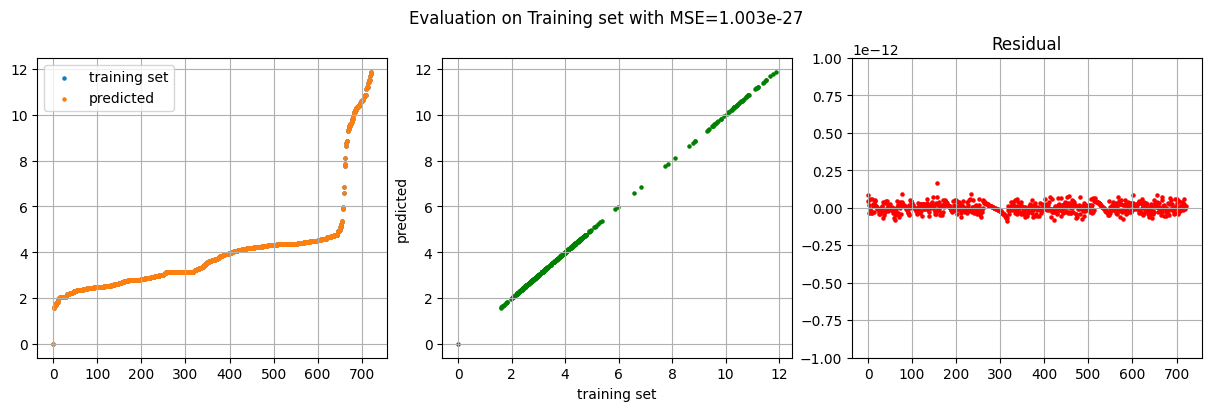

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
fig.suptitle(f"Evaluation on Training set with MSE={mse_train:.3e}")

axsf = axs.flatten()

ax = axsf[0]
ax.scatter(x, b_sorted, s=5)
ax.scatter(x, y_sorted, s=5)

ax.legend(["training set", "predicted"])
ax.grid()


ax = axsf[1]
ax.scatter(b_sorted, y_sorted, s=5, c='g')
ax.grid()
ax.set_xlabel("training set")
ax.set_ylabel("predicted")


ax = axsf[2]
ax.scatter(x, b_sorted-y_sorted, s=5, c='red')

ax.grid()
ax.set_title("Residual")
ax.set_ylim([-1e-12,1e-12])

**Some ideas about this question:**


In [8]:
print(f"Sample size = {len(M)}, parameters size = {len(w)}")
print(f"Det(A.T @ A) = {np.linalg.det(A.T @ A)}")

Sample size = 722, parameters size = 1785
Det(A.T @ A) = 0.0


By the way, we know that for minimizing MSE by Least Square, the closed form solution is:
$$
w = (A^\mathsf{T}A)^{-1}A^\mathsf{T}b
$$
However, $\det(A^\mathsf{T}A) = 0$, $A^\mathsf{T}A$ is non-invertible. And the number of training samples is 722`(len(M) is 722)`, which is less than the dimension of parameters`(len(w) = 1785)`. That's why the closed-form doesn't work, and we can solve this by `numpy.linalg.lstsq`

---

**Question 3.3 :** 

Evaluate the quality of the solution found on the test set.

In [9]:
print(f"test set shape: {M_test.shape}")

test set shape: (361, 892)


In [10]:
y_test = A_test @ w
arrIndex = b_test.argsort()
b_test_sorted = b_test[arrIndex]
y_test_sorted = y_test[arrIndex]
x = range(len(b_test_sorted))
mse_test = MSE_Loss(b_test, y_test)

Text(0.5, 1.0, 'Residual')

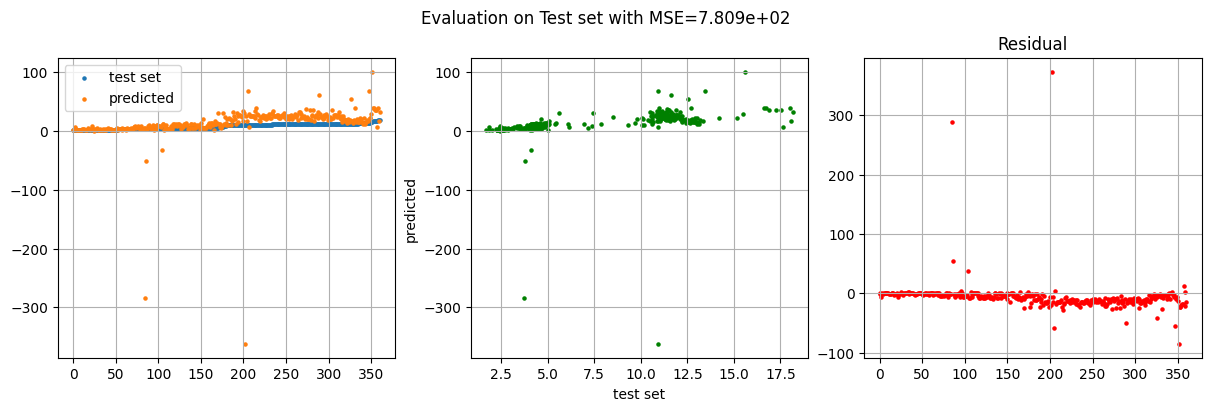

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
fig.suptitle(f"Evaluation on Test set with MSE={mse_test:.3e}")

axsf = axs.flatten()

ax = axsf[0]
ax.scatter(x, b_test_sorted, s=5)
ax.scatter(x, y_test_sorted, s=5)

ax.legend(["test set", "predicted"])
ax.grid()


ax = axsf[1]
ax.scatter(b_test_sorted, y_test_sorted, s=5, c='g')
ax.grid()
ax.set_xlabel("test set")
ax.set_ylabel("predicted")


ax = axsf[2]
ax.scatter(x, b_test_sorted-y_test_sorted, s=5, c='red')

ax.grid()
ax.set_title("Residual")
# ax.set_ylim([-1e-12,1e-12])

Text(0.5, 1.0, 'Distribution of residual on test set')

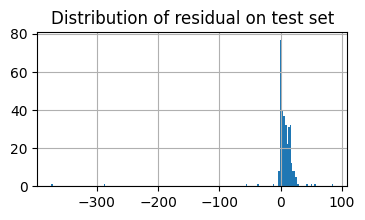

In [12]:
fig = plt.figure(figsize=(4,2))
diff = y_test - b_test
_ = plt.hist(diff, bins=200)
plt.grid()
plt.title("Distribution of residual on test set")

---

**Question 3.4**

In order to improve the generalization power of the model, we consider a $l_2$ regularization :
$$
\min_w \frac{1}{2} \|Aw - b\|_2^2 + \frac{\lambda}{2} \|w\|^2
$$
where $\lambda = 100$. Solve this problem and compare the test mean square error with the unregularized one.


**Answer :**

As there is no specification here regarding the method to solve this problem, the following questions require us to use the gradient descent method. Therefore, we first provide an answer using closed form solution for comparison with the unregularized case. Later on, we will implement a gradient descent-like algorithm in code.

The closed-form solution:

$$
w = (A^\mathsf{T}A + \lambda \mathbf{I})^{-1}A^\mathsf{T}b
$$

$(A^\mathsf{T}A + \lambda \mathbf{I})$ is inversible because $A^\mathsf{T}A$ is positive semi-definite and $\lambda > 0$. 

By this way, we evaluate this solution on test set, the MSE is 301, which is lower than the unregularized case (781). 

In [13]:
w = np.linalg.inv(A.T @ A + 100 * np.eye(A.shape[1])) @ A.T @ b

In [14]:
y_test = A_test @ w
arrIndex = b_test.argsort()
b_test_sorted = b_test[arrIndex]
y_test_sorted = y_test[arrIndex]
x = range(len(b_test_sorted))
mse_test = MSE_Loss(b_test, y_test)

Text(0.5, 1.0, 'Residual')

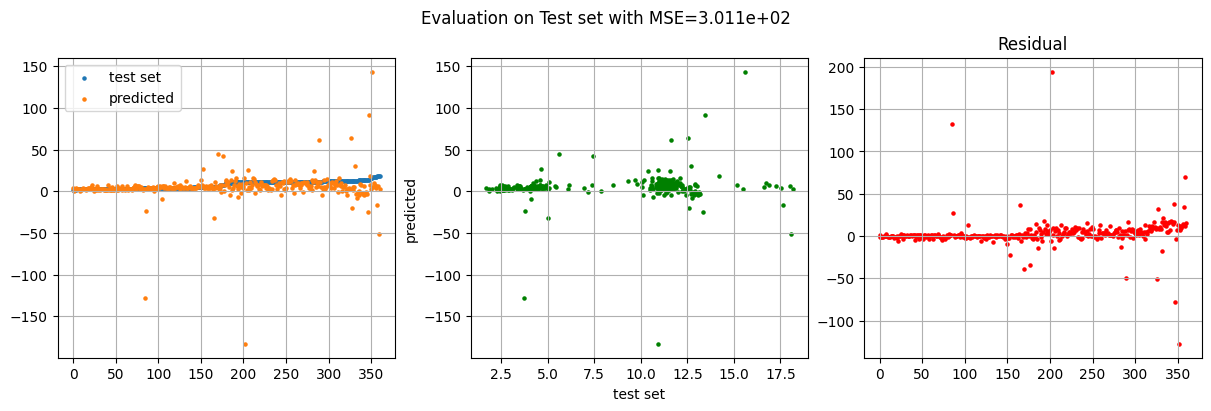

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
fig.suptitle(f"Evaluation on Test set with MSE={mse_test:.3e}")

axsf = axs.flatten()

ax = axsf[0]
ax.scatter(x, b_test_sorted, s=5)
ax.scatter(x, y_test_sorted, s=5)

ax.legend(["test set", "predicted"])
ax.grid()


ax = axsf[1]
ax.scatter(b_test_sorted, y_test_sorted, s=5, c='g')
ax.grid()
ax.set_xlabel("test set")
ax.set_ylabel("predicted")


ax = axsf[2]
ax.scatter(x, b_test_sorted-y_test_sorted, s=5, c='red')

ax.grid()
ax.set_title("Residual")
# ax.set_ylim([-1e-12,1e-12])

---

**Question 3.5**

Calculate the gradient of $f_1 : w \mapsto \frac{1}{2} \|Aw - b\|_2^2 + \frac{\lambda}{2} \|w\|^2$. Is the function convex?

The gradient is:
$$
\nabla{f_1} = A^{\mathsf{T}}(Aw - b) + \lambda w
$$

The second-order gradient:
$$
\nabla^2{f_1} = A^{\mathsf{T}}A + \lambda \mathbf{I}
$$

$\nabla^2{f_1}$  is sum of a positive semi-definite matrix and a positive diagonal matrix. $\nabla^2{f_1}$  is positive semi-definite, so $f_1$ is convex.

---

**Question 3.6**

Implement gradient descent to minimize $f_1$. What step size are you choosing ? How many iterations are needed to get $w_k$ such that $\| \nabla f(w_k)\| \leq 1$ ?

Step size $\alpha$ is set to 2e-7, 367132 iterations are used for $\| \nabla f(w_k)\| \leq 1$.

In [16]:
class Ridge(object):
    def __init__(self, lam=0.1, eps=1e-3, max_epoch_num=100, alpha=1e-5) -> None:
        self.lam = lam
        self.eps = eps
        self.max_epoch_num = max_epoch_num 
        self.alpha = alpha
        self.history = defaultdict(list)
        self.w = None 

    def _grad(self, X):
        return X.T @ (X @ self.w - b) + self.lam * self.w
    
    def _loss(self, X, b):
        return 0.5 * np.linalg.norm(X @ self.w - b) + 0.5 * self.lam * np.linalg.norm(self.w)
    
    def _mse(self, X, b):
        y = X @ self.w
        return np.average((b - y)**2)

    def fit(self, X, b, log=False): 

        self.w = np.random.rand(X.shape[1])

        for i in range(self.max_epoch_num):
            grad = self._grad(X)

            self.w = self.w - self.alpha * grad

            norm = np.linalg.norm(grad)

            if log:
                self.history["loss"].append(self._loss(X, b))
                self.history["mse"].append(self._loss(X, b))
                self.history["grad"].append(norm)
                
            if norm < self.eps:
                print("norm of gradient less than epsilon")
                break

        loss = self._loss(X, b)
        mse = self._mse(X, b)
        norm_grad = np.linalg.norm(grad)

        print(f"Final: loss={loss}, final mse={mse}, norm(grad) = {norm_grad}")

        return self.w, i, loss, mse
        

In [19]:
S1 = Ridge(lam=100, eps=1, max_epoch_num=500000, alpha=2e-7)

In [20]:
w, i, *_ = S1.fit(A, b, log=False)

norm of gradient less than epsilon
Final: loss=112.1843930903186, final mse=0.21291878366562533, norm(grad) = 0.9999809723933498


In [22]:
print(f"Iteration used: {i+1}")

Iteration used: 367132


In [23]:
y_test = A_test @ w
arrIndex = b_test.argsort()
b_test_sorted = b_test[arrIndex]
y_test_sorted = y_test[arrIndex]
x = range(len(b_test_sorted))
mse_test = MSE_Loss(b_test, y_test)

Text(0.5, 1.0, 'Residual')

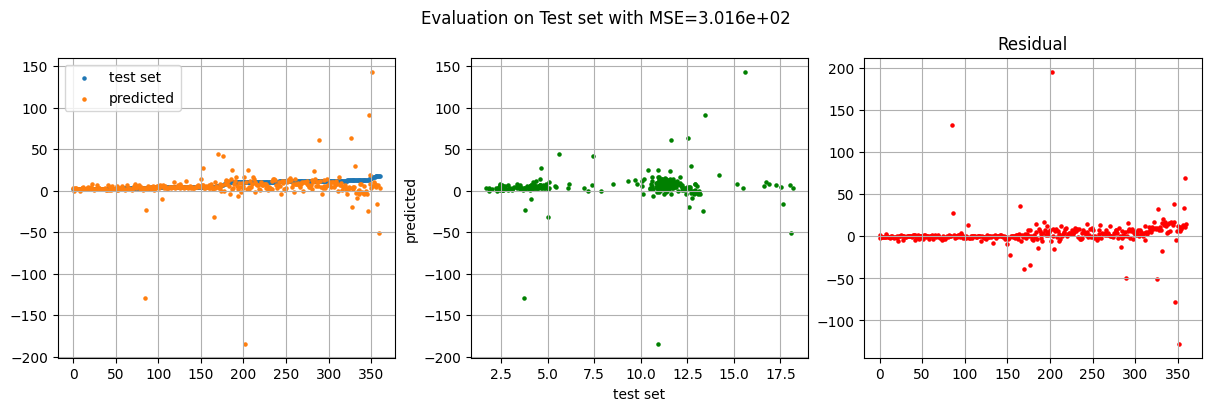

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
fig.suptitle(f"Evaluation on Test set with MSE={mse_test:.3e}")

axsf = axs.flatten()

ax = axsf[0]
ax.scatter(x, b_test_sorted, s=5)
ax.scatter(x, y_test_sorted, s=5)

ax.legend(["test set", "predicted"])
ax.grid()


ax = axsf[1]
ax.scatter(b_test_sorted, y_test_sorted, s=5, c='g')
ax.grid()
ax.set_xlabel("test set")
ax.set_ylabel("predicted")


ax = axsf[2]
ax.scatter(x, b_test_sorted-y_test_sorted, s=5, c='red')

ax.grid()
ax.set_title("Residual")
# ax.set_ylim([-1e-12,1e-12])

---

---

## 2.2  Regularization for a sparse model

**Question 4.1**


$$
\begin{align*}
\mathrm{prox}_{g_2} &= \arg \min_{w} g_2(w) + \frac{1}{2}\| x - w \|^2 \\
&= \arg \min_{w}\lambda \|w\|_1 + \frac{1}{2}\| x - w \|^2
\end{align*}
$$

**Question 4.2 and rest questions**




[Github](https://github.com/Lupin2019/tele_comme_pari/tree/dev/SD211/TP_least_squares)

---
---